This post is a rough guide to implementing real-time adjustments to CHLA values in Argo NetCDF files. The real-time adjustments are relatively new and reflect a balance between simplicity and completeness, with the understanding that delayed-mode QC will be more robust and incorporate more float-specific considerations. In case it's not clear, nothing in this post should be construed as a definitive QC implementation and should be subject to considerable testing prior to deployment as actual live QC.

To implement the tests on existing ArgoNetCDF files in Python, we'll use the [argopandas](https://github.com/ArgoCanada/argopandas) package (to list float profiles and do some basic interaction with Argo NetCDF files) and [gsw](https://teos-10.github.io/GSW-Python/) (to perform seawater calculations required for some of the checks). We'll also use [pandas](https://pandas.pydata.org/) data frames and [numpy](https://numpy.org/) arrays to marshal the generic data handling and [matplotlib](https://matplotlib.org/) to plot as we go along.

In [ ]:
# pip install argopandas gsw matplotlib
# conda install -c conda-forge argopandas gsw matplotlib
import argopandas as argo
import gsw
import numpy as np
import matplotlib.pyplot as plt

### Example data

We'll need some data to practice with, too. As an example, I'll use all the profiles from float 6904117. It's probably best to use a fresh cache for every Python session (the default), but for the purposes of rendering this post I'll use a local cache to avoid downloading the files everytime I render it.

In [ ]:
profiles = argo.prof \
    .subset_float(6904117) \
    .subset_direction('ascending') 
bgc_profiles = argo.bio_prof \
    .subset_float(6904117) \
    .subset_direction('ascending')

In [ ]:
profiles

In [ ]:
bgc_profiles

### The recipe

As I understand it, this is what has to happen to the real-time measurements during the CHLA processing:

- `CHLA` values whose flags are unset are flagged as `Flag.PROBABLY_BAD`
- `CHLA_ADJUSTED` values whose flags are unset are flagged as `Flag.GOOD`
- Apply global range test (flag for `CHLA` and `CHLA_ADJUSTED` set to `Flag.BAD` for CHLA values outside the range -0.1 to 100)
- Apply the "dark correction" to `CHLA` values:
    - Read the `SCIENTIFIC_CALIB_COEFFICIENT` variable for the CHLA profile and parse the `FLOAT_DARK`, and `FLOAT_DARK_QC` values. It is likely that `FLOAT_DARK_QC` doesn't exist in any files yet, so default to `Flag.NO_QC`. For profiles that haven't gone through 5 cycles deeper than the "mixed layer depth", there should be a `PRELIM_DARK` variable in `SCIENTIFIC_CALIB_COEFFICIENT`
    - If `FLOAT_DARK` exists, apply the equation `CHLA_ADJUSTED = ((FLUORESCENCE_CHLA-FLOAT_DARK)*SCALE_CHLA)/2`.
    - If it doesn't, calculate try to calculate `PRELIM_DARK` and look for 4 previous instances of `PRELIM_DARK` with which `FLOAT_DARK/_QC` should be calculated. If there are 5 `PRELIM_DARK` values, calculate `FLOAT_DARK/_QC` and use that. If there aren't calculate the adjusted value using `PRELIM_DARK`.
- Apply the non-photochemical quenching correction (NPC) to the value calculated by the dark correction. This is the correction for the upper portion of the ocean whereby phytoplankton have a reduced response to UV light because they have already been exposed to it from the sun.

A few of these steps have details that need to be expanded upon, so let's do those first

### QC Flags

In addition to computing adjusted realtime values, the QC checks for CHLA also flag some values using the Argo flag scheme. One of the challeneges in doing this is that you don't want to make a data point look "better" by assigning a QC flag (e.g., flag a value as "probably bad" when it's already been flagged as "bad"). This logic was implemented by the experimental [argortqcpy](https://github.com/euroargodev/argortqcpy) package ([here](https://github.com/euroargodev/argortqcpy/blame/main/argortqcpy/checks.py)) and I've modified it slightly to get all of the flag logic in one happy Python class:

In [ ]:
class Flag:
    """
    Flags for check output. These values are valid values of the
    ``qc`` and ``adjusted_qc`` attributes of a
    :class:`~medsrtqc.core.Trace` object. Utility functions are
    provided as static methods to get the name or value of a flag
    or to update flag values ensuring that values that are already
    marked at a "worse" QC level are not inadvertently changed.
    """

    @staticmethod
    def label(flag):
        """Return the label of a QC flag"""
        return Flag._names[flag]

    @staticmethod
    def value(label):
        """Return the value of a QC flag"""
        for value, lab in Flag._names.items():
            if label == lab:
                return value
        raise KeyError(f"'{label}' is not the name of a QC flag")

    @staticmethod
    def update_safely(qc, to, where=None):
        """
        Safely update ``qc`` to the value ``to``. Values that are
        already marked at a "worse" QC level are not modified.
        """
        where = slice(None) if where is None else where
        flags = qc[where]
        for overridable_flag in Flag._precedence[to]:
            flags[flags == overridable_flag] = to
        qc[where] = flags

    NO_QC = b'0'
    GOOD = b'1'
    PROBABLY_GOOD = b'2'
    PROBABLY_BAD = b'3'
    BAD = b'4'
    CHANGED = b'5'
    # '6' not used
    # '7' not used
    ESTIMATED = b'8'
    MISSING = b'9'
    FILL_VALUE = b''

    _names = {
        NO_QC: 'NO_QC',
        GOOD: 'GOOD',
        PROBABLY_GOOD: 'PROBABLY_GOOD',
        PROBABLY_BAD: 'PROBABLY_BAD',
        BAD: 'BAD',
        CHANGED: 'CHANGED',
        ESTIMATED: 'ESTIMATED',
        MISSING: 'MISSING',
        FILL_VALUE: 'FILL_VALUE'
    }

    _precedence = {
        NO_QC: set(),
        GOOD: {
            NO_QC,
        },
        PROBABLY_GOOD: {
            NO_QC,
            GOOD,
            CHANGED,
        },
        PROBABLY_BAD: {
            NO_QC,
            GOOD,
            PROBABLY_GOOD,
            CHANGED,
        },
        BAD: {
            NO_QC,
            GOOD,
            PROBABLY_GOOD,
            CHANGED,
            PROBABLY_BAD,
        },
        CHANGED: {
            NO_QC,
        },
        ESTIMATED: {
            NO_QC,
            GOOD,
            PROBABLY_GOOD,
        },
        MISSING: {
            NO_QC,
        },
    }

### Parsing SCIENTIFIC_CALIB_COEFFICIENT

This variable in the NetCDF files looks like this:

```
DARK_CHLA = 47, SCALE_CHLA = 0.0073
```

and is in string form. It can be parsed by splitting a few times to return a `dict()` and reconstituted by pasting together a few times.

In [ ]:
def parse_scientific_calib_coefficient(val):
    parts = val.split(',')
    vals =  [part.split('=') for part in parts]
    return {k.strip(): float(v.strip()) for k, v in vals}

def unparse_calib_coefficient(coefs):
    return ', '.join(f'{k} = {v}' for k, v in coefs.items())

coefs = parse_scientific_calib_coefficient('DARK_CHLA = 47, SCALE_CHLA = 0.0073')
print(coefs)
coefs['SOMETHING_ELSE'] = 1.23
unparse_calib_coefficient(coefs)

### The mixed layer depth

As I understand it, there are as many ways to calculate the mixed layer depth as there are oceanographers. The following is an implementation based on the guidance provided in the draft CHLA QC document. I'm using `plt` as an argument here so that you can debug this stuff interactively (but skip installing matplotlib in production). The gist is that it looks for density changes > 0.03 below 10 dbar.

In [ ]:
import gsw

def calc_mixed_layer_depth(pres, temp, psal, longitude=0, latitude=0, plt=None):
    abs_salinity = gsw.SA_from_SP(psal.value, pres.value, longitude, latitude)
    conservative_temp = gsw.CT_from_t(abs_salinity, temp.value, pres.value)
    density = gsw.sigma0(abs_salinity, conservative_temp)

    if plt:
        plt.plot(density, pres.value)
        plt.gca().invert_yaxis()
        plt.gca().set_xlabel('sigma0')

    mixed_layer_start = (np.diff(density) > 0.03) & (pres.value[:-1] > 10)
    if not np.any(mixed_layer_start):
        # Can't determine mixed layer depth (no density changes > 0.03 below 10 dbar)
        return None

    mixed_layer_start_index = np.where(mixed_layer_start)[0][0]
    mixed_layer_depth = pres.value[mixed_layer_start_index]

    if plt:
        plt.gca().axhline(y = mixed_layer_depth, linestyle='--')

    return mixed_layer_depth

### Calculating FLOAT_DARK

The guidance on calculating `PRELIM_DARK` is that it's the minimum `CHLA` value below the mixed layer depth boundary. In Python:

In [ ]:
def calc_prelim_dark(pres, chla, mixed_layer_depth):
    chla_filter = chla[pres > mixed_layer_depth]
    if len(chla_filter) > 0:
        return chla_filter.min()
    else:
        return None

Calculating `FLOAT_DARK` is a little more involved and it's where we'll make use of our float/cycle index that we created earlier. We need to start from the first NetCDF file for the float and collect any `PRELIM_DARK` values from `SCIENTIFIC_CALIB_COEFFICIENT` that might have been calculated. If there were 3 or fewer, we do nothing. If there are exactly 4, we add our `PRELIM_DARK` that we just calculated, calculate the mean of the values, and use that. The `FLOAT_DARK_QC` gets added based on the standard deviation of the `PRELIM_DARK` values.

In [ ]:
def calc_float_dark(bio_prof_files):
    prelim_dark = []
    for nc in argo.nc(bio_prof_files):
        coefs_df = nc.calib[nc.calib.PARAMETER.str.strip() == 'CHLA'] \
            .filter(['SCIENTIFIC_CALIB_COEFFICIENT'])
        if len(coefs_df) == 0 or 'SCIENTIFIC_CALIB_COEFFICIENT' not in coefs_df:
            continue

        coefs = parse_scientific_calib_coefficient(coefs_df.iloc[0][0])
        if 'PRELIM_DARK' not in coefs:
            continue
            
        prelim_dark.append(coefs['PRELIM_DARK'])
    
    return np.array(prelim_dark)

calc_float_dark(['dac/' + f for f in bgc_profiles.head(10).file])

An empty result here is expected since the scheme was just invented. However, `FLOAT_DARK` *does* exist everywhere, so we can just use that for these calculations.

### The whole game

The rest is not very oceanographic but does involve navigating the structure of BGC variables' encoding in Argo profile NetCDFs. First, we get a `NetCDFWrapper` handle and a local filename to the .nc file. In argopandas, a `NetCDFWrapper` is a thin wrapper around a `netCDF4.Dataset` that implements a few common accessors in addition to the most common accessors for the dataset (notably, `obj.variables` and `obj['variable name']`).

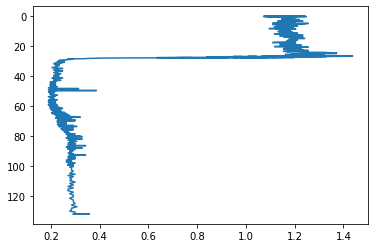

In [127]:
nc_filename = argo.filename('dac/coriolis/6904117/profiles/BR6904117_171.nc')
nc = argo.nc(nc_filename)

# make sure we've got a CHLA variable
if 'CHLA' not in nc.variables or 'PRES' not in nc.variables:
    raise KeyError(f"'CHLA' or 'PRES' not found in '{nc_filename}'")

# find the profile index associated with CHLA
chla_prof_i = nc.param[nc.param.STATION_PARAMETERS.str.strip() == 'CHLA'] \
    .reset_index() \
    .iloc[0] \
    .N_PROF

# get the PRES/CHLA/CHLA_QC series we'll work with
# (note that there will be trailing NaN values here
# but we want to keep those because we'll have to keep the
# size the same to reassign values to a copy later)
pres = nc['PRES'][:][chla_prof_i]
chla = nc['CHLA'][:][chla_prof_i]
chla_qc = nc['CHLA_QC'][:][chla_prof_i]

# create the chla_adjusted and chla_qc variables from originals
chla_adjusted = chla.copy()
chla_adjusted_qc = chla_qc.copy()

# reset chla_qc to Flag.NO_QC
chla_qc[:] = Flag.NO_QC

# plot to verify!
plt.plot(chla, pres)
plt.gca().invert_yaxis()

The first step is to set the initial QC values to `Flag.PROBABLY_BAD`.

In [128]:
chla_qc[:] = Flag.PROBABLY_BAD
chla_adjusted_qc = Flag.GOOD

Then we apply the global range test:

In [129]:
chla_qc = Flag.update_safely(chla_qc, Flag.BAD, where=(chla < 0.1) | (chla > 100))

In [126]:
nc = argo.nc('profiles/BR6904117_171.nc')
nc.levels[~np.isnan(nc.levels.CHLA)]
nc.param[nc.param.STATION_PARAMETERS.str.strip() == 'CHLA']

,,STATION_PARAMETERS,PARAMETER_DATA_MODE
N_PROF,N_PARAM,,
4,5,CHLA ...,b'A'


In [ ]:
eqn = nc.calib[nc.calib.PARAMETER.str.strip() == 'CHLA'] \
    .filter(['PARAMTER', 'SCIENTIFIC_CALIB_EQUATION', 'SCIENTIFIC_CALIB_COEFFICIENT'])
eqn.iloc[0][1]

In [ ]:
nc.calib

### Tests

In the course of writing all of this I also wrote some unit tests and it's worth putting them here so they don't get lost!

In [ ]:
import unittest

class TestFlag(unittest.TestCase):

    def test_value(self):
        self.assertEqual(Flag.NO_QC, Flag.value('NO_QC'))
        self.assertEqual(Flag.label(Flag.NO_QC), 'NO_QC')
        with self.assertRaises(KeyError):
            Flag.value('not a QC key')
        with self.assertRaises(KeyError):
            Flag.label(b'def not a flag')

    def test_update(self):
        qc = np.array([Flag.GOOD, Flag.PROBABLY_BAD, Flag.MISSING])
        Flag.update_safely(qc, to=Flag.BAD)
        self.assertTrue(np.all(qc == np.array([Flag.BAD, Flag.BAD, Flag.MISSING])))

        qc = np.array([Flag.GOOD, Flag.PROBABLY_BAD, Flag.MISSING])
        Flag.update_safely(qc, to=Flag.BAD, where=np.array([False, True, False]))
        self.assertTrue(np.all(qc == np.array([Flag.GOOD, Flag.BAD, Flag.MISSING])))
